In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision

import os
import sys
import time
import logging
import argparse
import numpy as np
import shutil
import torchvision.transforms as transforms
from torch.autograd import Variable

In [ ]:
cudnn.enabled = True
cudnn.benchmark = True

In [ ]:
seed = 0

In [ ]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
best_acc = 0

In [ ]:
class Cutout(object):
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - self.length // 2, 0, h)
        y2 = np.clip(y + self.length // 2, 0, h)
        x1 = np.clip(x - self.length // 2, 0, w)
        x2 = np.clip(x + self.length // 2, 0, w)

        mask[y1: y2, x1: x2] = 0.
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img

In [ ]:
def _data_transforms_cifar10(cutout):
    CIFAR_MEAN = [0.49139968, 0.48215827, 0.44653124]
    CIFAR_STD = [0.24703233, 0.24348505, 0.26158768]

    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

    if cutout:
        train_transform.transforms.append(Cutout(16))

    train_transform.transforms.append(transforms.Normalize(CIFAR_MEAN, CIFAR_STD))

    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
    ])
    return train_transform, valid_transform, valid_transform

In [ ]:
import torch
import torch.nn as nn
from copy import copy
from abc import ABC, abstractmethod
from collections import OrderedDict


class Decoder(ABC):
    """
    Abstract genome decoder class.
    """

    @abstractmethod
    def __init__(self, list_genome):
        """
        :param list_genome: genome represented as a list.
        """
        self._genome = list_genome

    @abstractmethod
    def get_model(self):
        raise NotImplementedError()


class ChannelBasedDecoder(Decoder):
    """
    Channel based decoder that deals with encapsulating constructor logic.
    """

    def __init__(self, list_genome, channels, repeats=None):
        """
        Constructor.
        :param list_genome: list, genome describing the connections in a network.
        :param channels: list, list of tuples describing the channel size changes.
        :param repeats: None | list, list of integers describing how many times to repeat each phase.
        """
        super().__init__(list_genome)

        self._model = None

        # First, we remove all inactive phases.
        self._genome = self.get_effective_genome(list_genome)
        self._channels = channels[:len(self._genome)]

        # Use the provided repeats list, or a list of all ones (only repeat each phase once).
        if repeats is not None:
            # First select only the repeats that are active in the list_genome.
            active_repeats = []
            for idx, gene in enumerate(list_genome):
                if phase_active(gene):
                    active_repeats.append(repeats[idx])

            self.adjust_for_repeats(active_repeats)
        else:
            # Each phase only repeated once.
            self._repeats = [1 for _ in self._genome]

        # If we had no active nodes, our model is just the identity, and we stop constructing.
        if not self._genome:
            self._model = Identity()

        # print(list_genome)

    def adjust_for_repeats(self, repeats):
        """
        Adjust for repetition of phases.
        :param repeats:
        """
        self._repeats = repeats

        # Adjust channels and genome to agree with repeats.
        repeated_genome = []
        repeated_channels = []
        for i, repeat in enumerate(self._repeats):
            for j in range(repeat):
                if j == 0:
                    # This is the first instance of this repeat, we need to use the (in, out) channel convention.
                    repeated_channels.append((self._channels[i][0], self._channels[i][1]))
                else:
                    # This is not the first instance, use the (out, out) convention.
                    repeated_channels.append((self._channels[i][1], self._channels[i][1]))

                repeated_genome.append(self._genome[i])

        self._genome = repeated_genome
        self._channels = repeated_channels

    def build_layers(self, phases):
        """
        Build up the layers with transitions.
        :param phases: list of phases
        :return: list of layers (the model).
        """
        layers = []
        last_phase = phases.pop()
        for phase, repeat in zip(phases, self._repeats):
            for _ in range(repeat):
                layers.append(phase)
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # TODO: Generalize this, or consider a new genome.

        layers.append(last_phase)
        return layers

    @staticmethod
    def get_effective_genome(genome):
        """
        Get only the parts of the genome that are active.
        :param genome: list, represents the genome
        :return: list
        """
        return [gene for gene in genome if phase_active(gene)]

    @abstractmethod
    def get_model(self):
        raise NotImplementedError()


class HourGlassDecoder(Decoder):
    """
    Decoder that deals with HourGlass-type networks.
    """

    def __init__(self, genome, n_stacks, out_feature_maps):
        """
        Constructor.
        :param genome: list, list of ints.
        :param n_stacks: int, number of hourglasses to use.
        :param out_feature_maps: int, number of output feature maps.
        """
        super().__init__(genome)

        self.n_stacks = n_stacks
        self.out_feature_maps = out_feature_maps

    @abstractmethod
    def get_model(self):
        raise NotImplementedError()

    @staticmethod
    @abstractmethod
    def check_genome(genome):
        raise NotImplementedError()


class LOSHourGlassDecoder(HourGlassDecoder, nn.Module):
    """
    Line of sight HourGlass decoder.
    """

    STEP_TOLERANCE = 2  # A network can step as much as
    GENE_LB = 0  # Gene must be greater than this value.
    GENE_UB = 6  # Gene must be less than this value.

    def __init__(self, genome, n_stacks, out_feature_maps, pre_hourglass_channels=32, hourglass_channels=64):
        """
        Constructor.
        :param genome: list, list of ints satisfying properties defined in self.valid_genome.
        :param n_stacks: int, number of hourglasses to use.
        :param out_feature_maps, int, number of output feature maps.
        """
        HourGlassDecoder.__init__(self, genome, n_stacks, out_feature_maps)
        nn.Module.__init__(self)

        self.pre_hourglass_channels = pre_hourglass_channels
        self.hourglass_channels = hourglass_channels

        self.check_genome(genome)

        # Initial resolution reducing, takes 256 x 256 to 64 x 64
        self.initial = nn.Sequential(
            nn.Conv2d(3, self.pre_hourglass_channels, kernel_size=7, stride=2, padding=3, bias=True),
            nn.BatchNorm2d(self.pre_hourglass_channels),
            nn.ReLU(inplace=True),
            HourGlassResidual(self.pre_hourglass_channels, self.pre_hourglass_channels)
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.secondary = nn.Sequential(
            HourGlassResidual(self.pre_hourglass_channels, self.pre_hourglass_channels),
            HourGlassResidual(self.pre_hourglass_channels, self.hourglass_channels)
        )

        #
        # Evolved part follows.
        #
        graph = LOSComputationGraph(genome)  # The evolved computation graph.
        hg_channels = self.hourglass_channels * LOSHourGlassBlock.EXPANSION  # Number of channels output by the hourglass.

        # List of hourglasses, deep copy of hourglass constructed above.
        hourglasses = [LOSHourGlassBlock(graph, self.hourglass_channels, hg_channels)]

        # Lin layers run on the output of the hourglass.
        first_lin = [Lin(hg_channels, hg_channels)]
        second_lin = [Lin(hg_channels, self.hourglass_channels)]

        # 1x1 convs to adjust channels to fit number of scoremaps.
        to_score_map = [nn.Conv2d(self.hourglass_channels, out_feature_maps, kernel_size=1, bias=True)]
        # 1x1 convs to adjust scoremap back to appropriate feature map count.
        from_score_map = [nn.Conv2d(out_feature_maps, self.hourglass_channels + self.pre_hourglass_channels, kernel_size=1, bias=True)]

        # 1x1 convs for the skip connection that skips the hourglass.
        skip_convs = [nn.Conv2d(self.hourglass_channels + self.pre_hourglass_channels, self.hourglass_channels + self.pre_hourglass_channels,
                                kernel_size=1, bias=True)]

        skip_channels = self.pre_hourglass_channels

        #
        # The above and proceeding code is overly complex to deal with the fact that the first skip connection will
        # have less channels than the rest of the network, as specified in the original implementation.
        #

        for i in range(1, n_stacks):
            hourglasses.append(LOSHourGlassBlock(graph, self.hourglass_channels + skip_channels, hg_channels))
            first_lin.append(Lin(hg_channels, hg_channels))

            to_score_map.append(nn.Conv2d(self.hourglass_channels, out_feature_maps, kernel_size=1, bias=True))
            second_lin.append(Lin(hg_channels, self.hourglass_channels))

            # We only need go back to the original channel sizes from the score maps n - 1 times.
            if i < n_stacks - 1:
                skip_convs.append(nn.Conv2d(hg_channels, hg_channels, kernel_size=1, bias=True))
                from_score_map.append(nn.Conv2d(out_feature_maps, hg_channels, kernel_size=1,
                                                bias=True))

            skip_channels = self.hourglass_channels

        # Register everything by converting to ModuleLists.
        self.hourglasses = nn.ModuleList(hourglasses)
        self.first_lin = nn.ModuleList(first_lin)
        self.to_score_map = nn.ModuleList(to_score_map)
        self.from_score_map = nn.ModuleList(from_score_map)
        self.second_lin = nn.ModuleList(second_lin)
        self.skip_convs = nn.ModuleList(skip_convs)

    @staticmethod
    def check_genome(genome):
        """
        Make sure the genome is valid.
        :param genome: list, list of ints, representing the genome.
        :raises AssertionError: if genome is not valid.
        """
        assert isinstance(genome[0], int), "Genome should be a list of integers."

        for gene in genome:
            assert LOSHourGlassDecoder.GENE_LB < gene < LOSHourGlassDecoder.GENE_UB, \
                "{} is an invalid gene value, must be in range [{}, {}]".format(gene,
                                                                                LOSHourGlassDecoder.GENE_LB,
                                                                                LOSHourGlassDecoder.GENE_UB)
        for i in range(len(genome) - 1):
            step = abs(genome[i] - genome[i + 1])
            assert step <= LOSHourGlassDecoder.STEP_TOLERANCE, \
                "Attempted to step {} resolutions, cannot step more than 2 resolutions.".format(step)

    def get_model(self):
        """
        In other decoders, we'd return a module object, but since self is an nn.Module, we return self.
        :return: self
        """
        return self

    def forward(self, x):
        """
        Forward operation.
        :param x: Variable, input
        :return: list, list of Variables, intermediate and final score maps.
        """
        maps = []

        x = self.initial(x)
        x = self.pool(x)

        skip = x.clone()

        x = self.secondary(x)

        for i in range(self.n_stacks):
            y = self.hourglasses[i](x)
            y = self.first_lin[i](y)
            y = self.second_lin[i](y)

            next_skip = y.clone()

            score_map = self.to_score_map[i](y)

            maps.append(score_map)

            # We only need to map back from the score feature maps and do skip connection n - 1 times.
            if i < self.n_stacks - 1:
                z = self.from_score_map[i](score_map)
                a = torch.cat((y, skip), dim=1)
                a = self.skip_convs[i](a)

                x = z + a

            skip = next_skip

        return maps


class Lin(nn.Module):
    """
    "Lin" layer as implemented in: https://github.com/umich-vl/pose-hg-demo/blob/master/stacked-hourglass-model.lua
    """
    def __init__(self, in_channels, out_channels):
        """
        Constructor.
        :param in_channels: int, input channels.
        :param out_channels: int, desired output channels.
        """
        super(Lin, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.model(x)


class LOSHourGlassBlock(nn.Module):
    """
    HourGlassBlock, repeated in an hourglass-type network.
    """

    EXPANSION = 2  # Hour glass block will increase channels by a factor of 2.

    def __init__(self, graph, in_channels, out_channels, operating_channels=64):
        """
        Constructor.
        :param graph: decoder.LOSComputationGraph, represents the computation flow.
        :param in_channels: int, number of input channels.
        :param out_channels: int, number of output channels.
        """
        super(LOSHourGlassBlock, self).__init__()

        self.operating_channels = operating_channels

        self.graph = graph
        samplers = []
        nodes, _ = zip(*self.graph.items())
        nodes = [None] + list(nodes) + [None]  # Append none's to downsample input and upsample output if needed.
        for i in range(len(nodes[:-1])):
            samplers.append(self.make_sampling(nodes[i], nodes[i + 1]))

        self.samplers = nn.ModuleList(samplers)

        skip_ops = []  # HourGlassResiduals for the skip connections
        for node in graph.keys():
            if node.residual:
                skip_ops.append(HourGlassResidual(self.operating_channels, self.operating_channels))

            else:
                skip_ops.append(None)  # Filler to make the indices match

        last_node = list(graph.keys())[-1]
        res = last_node.residual_node
        if res:
            # If the last node receives a residual, we need to change the operation to output the right channel size.
            skip_ops[res.idx] = HourGlassResidual(self.operating_channels, out_channels)

        self.skip_ops = nn.ModuleList(skip_ops)

        path_ops = [HourGlassResidual(in_channels, self.operating_channels)]
        for i in range(len(graph) - 2):
            path_ops.append(HourGlassResidual(self.operating_channels, self.operating_channels))

        path_ops.append(HourGlassResidual(self.operating_channels, out_channels))

        self.path_ops = nn.ModuleList(path_ops)

    @staticmethod
    def make_sampling(prev_node, next_node):
        """
        Determine the factor of up/down sampling needed to move between two nodes.
        :param prev_node: LOSComputationGraph.Node | None.
        :param next_node: LOSComputationGraph.Node.
        :return: nn.MaxPool2d | nn.Upsample
        """
        if prev_node is None:
            # We're dealing with the first node (idx 0) so we need a placeholder node.
            prev_node = LOSComputationGraph.Node(1, -1)

        if next_node is None:
            next_node = LOSComputationGraph.Node(1, -1)

        if prev_node.resolution == next_node.resolution:
            # Nothing to be done.
            return Identity()

        elif prev_node.resolution > next_node.resolution:
            # We need to downsample.
            s = int(prev_node.resolution / next_node.resolution)
            return nn.MaxPool2d(kernel_size=2, stride=s)

        else:
            # We need to upsample.
            f = int(next_node.resolution / prev_node.resolution)
            return nn.Upsample(scale_factor=f, mode="nearest")

    def forward(self, x):
        residuals = [None for _ in range(len(self.graph))]

        for i, (node, _) in enumerate(self.graph.items()):
            x = self.samplers[i](x)

            x = self.path_ops[i](x)

            if node.residual:
                residuals[i] = self.skip_ops[i](x.clone())

            res = node.residual_node
            if res:
                # Current node receives a residual connection.
                x += residuals[res.idx]
                residuals[res.idx] = None  # Free some memory, we'll never need this again.

        return self.samplers[-1](x)


class LOSComputationGraph:
    """
    Graph to hold information about the computation going on in
    """
    class Node:
        """
        Node to hold information.
        """
        def __init__(self, resolution, idx, residual=False):
            """
            Constructor.
            :param resolution: int, the resolution of the image at this point.
            :param idx: int, the index of the node in the graph (feed-forward, so this is ok).
            :param residual: bool, true if output of this node is needed at some point later in the graph.
            """
            self.resolution, self.idx, self.residual = resolution, idx, residual
            self.residual_node = None  # If this node receives a residual, store it here.

        def __repr__(self):
            residual_str = ", saves residual" if self.residual else ""
            return "<Node index: {} resolution: {}".format(self.idx, self.resolution) + residual_str + ">"

        def __str__(self):
            return self.__repr__()

        def __lt__(self, other):
            assert isinstance(other, LOSComputationGraph.Node)
            return self.idx < other.idx

    def __init__(self, genome, under_connect=True):
        """
        Make the computation graph specified by the genoms.
        :param genome: list, list of ints representing a genome.
        """
        self.graph = LOSComputationGraph.make_graph(genome, under_connect)

    def __len__(self):
        return len(self.graph)

    def __iter__(self):
        return self.graph.__iter__()

    def items(self):
        return self.graph.items()

    def keys(self):
        return self.graph.keys()

    def values(self):
        return self.graph.values()

    def get_residual(self, node):
        """
        Determines if a particular node in the graph gets a residual connection.
        :param node: LOSComputationGraph.Node.
        :return: LOSComputationGraph.Node | None
        """
        if node in self.graph:
            for dep in self.graph[node]:
                if dep.resolution == node.resolution and dep.residual:
                    return dep

        return None

    @staticmethod
    def make_graph(genome, under_connect=True):
        """
        Make the computation graph.
        The is not exactly an adjacency list... The normal forward path through the network is as expected, but the
            skip connections are only listed in the receiving nodes, rather than the sending nodes.
            This makes things much easier when actually forward propagating.
        :param genome: list, list of ints representing a genome.
        :param under_connect: bool, if false, we will not allow "under connections".
            Where an under connection connects nodes that may occur below the current path. Ex:
            | X ----->  X ----->  X
            |   X --> X .. X --> X
            |     X  ......  X
            Where arrows are the normal residual connections and the dots are the optional under connections.
        :return: OrderedDict, dict of lists, adjacency list describing the computation graph.
        """
        adj = OrderedDict()

        nodes = [LOSComputationGraph.Node(pow(2, -(gene - 1)), i) for i, gene in enumerate(genome)]

        # Construct the initial path through the graph, each node is connected to the one at the index in front of it.
        # Read as "Gene i" and "Gene i plus one".
        for i, (gene_i, gene_ipo) in enumerate(zip(nodes, nodes[1:])):
            adj[gene_i] = [gene_ipo]

        adj[nodes[-1]] = []

        previous_resolutions = {}
        previous_node = nodes[0]
        for node, adj_list in adj.items():
            if node.resolution in previous_resolutions:
                # We have found a node that occurred before the current one with the same resolution.

                if previous_node.resolution < node.resolution or \
                   previous_node.resolution > node.resolution and under_connect:
                    # Either we upsampled or downsampled. We always mark a residual and update the previous resolution
                    # is we upsample. If we're allowing connections under the path, we do the same.
                    previous_resolutions[node.resolution].residual = True
                    node.residual_node = previous_resolutions[node.resolution]
                    previous_resolutions[node.resolution] = node

                else:
                    # There was no change in resolution, just update previous_resolutions at this value to be
                    # the current node.
                    previous_resolutions[node.resolution] = node

            else:
                # We did not find a node before the current one that had its particular resolution.
                previous_resolutions[node.resolution] = node

            previous_node = node

        return adj


class HourGlassResidual(nn.Module):
    """
    Hour glass residual, As defined in https://arxiv.org/pdf/1603.06937.pdf.
    Code converted from original lua: https://github.com/umich-vl/pose-hg-demo/blob/master/residual.lua
    """
    def __init__(self, in_channels, out_channels):
        super(HourGlassResidual, self).__init__()

        # 1x1 convolution to make the residual connection's channels match the output channels.
        self.skip_layer = Identity() if in_channels == out_channels else \
            nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=True), nn.BatchNorm2d(out_channels))

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 2, kernel_size=1, bias=True),
            nn.BatchNorm2d(out_channels // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // 2, out_channels // 2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // 2, out_channels, kernel_size=1, bias=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        """
        Apply forward propagation operation.
        :param x: Variable, input.
        :return: Variable
        """
        residual = x
        out = self.model(x)
        return out + self.skip_layer(residual)


class ResidualGenomeDecoder(ChannelBasedDecoder):
    """
    Genetic CNN genome decoder with residual bit.
    """

    def __init__(self, list_genome, channels, preact=False, repeats=None):
        """
        Constructor.
        :param list_genome: list, genome describing the connections in a network.
        :param channels: list, list of tuples describing the channel size changes.
        :param repeats: None | list, list of integers describing how many times to repeat each phase.
        """
        super().__init__(list_genome, channels, repeats=repeats)

        if self._model is not None:
            return  # Exit if the parent constructor set the model.

        # Build up the appropriate number of phases.
        phases = []
        for idx, (gene, (in_channels, out_channels)) in enumerate(zip(self._genome, self._channels)):
            phases.append(ResidualPhase(gene, in_channels, out_channels, idx, preact=preact))

        self._model = nn.Sequential(*self.build_layers(phases))

    def get_model(self):
        """
        :return: nn.Module
        """
        return self._model


class ResidualPhase(nn.Module):
    """
    Residual Genome phase.
    """

    def __init__(self, gene, in_channels, out_channels, idx, preact=False):
        """
        Constructor.
        :param gene: list, element of genome describing connections in this phase.
        :param in_channels: int, number of input channels.
        :param out_channels: int, number of output channels.
        :param idx: int, index in the network.
        :param preact: should we use the preactivation scheme?
        """
        super(ResidualPhase, self).__init__()

        self.channel_flag = in_channels != out_channels  # Flag to tell us if we need to increase channel size.
        self.first_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1 if idx != 0 else 3, stride=1, bias=False)
        self.dependency_graph = ResidualPhase.build_dependency_graph(gene)

        if preact:
            node_constructor = PreactResidualNode

        else:
            node_constructor = ResidualNode

        nodes = []
        for i in range(len(gene)):
            if len(self.dependency_graph[i + 1]) > 0:
                nodes.append(node_constructor(out_channels, out_channels))
            else:
                nodes.append(None)  # Module list will ignore NoneType.

        self.nodes = nn.ModuleList(nodes)

        #
        # At this point, we know which nodes will be receiving input from where.
        # So, we build the 1x1 convolutions that will deal with the depth-wise concatenations.
        #
        conv1x1s = [Identity()] + [Identity() for _ in range(max(self.dependency_graph.keys()))]
        for node_idx, dependencies in self.dependency_graph.items():
            if len(dependencies) > 1:
                conv1x1s[node_idx] = \
                    nn.Conv2d(len(dependencies) * out_channels, out_channels, kernel_size=1, bias=False)

        self.processors = nn.ModuleList(conv1x1s)
        self.out = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    @staticmethod
    def build_dependency_graph(gene):
        """
        Build a graph describing the connections of a phase.
        "Repairs" made are as follows:
            - If a node has no input, but gives output, connect it to the input node (index 0 in outputs).
            - If a node has input, but no output, connect it to the output node (value returned from forward method).
        :param gene: gene describing the phase connections.
        :return: dict
        """
        graph = {}
        residual = gene[-1][0] == 1

        # First pass, build the graph without repairs.
        graph[1] = []
        for i in range(len(gene) - 1):
            graph[i + 2] = [j + 1 for j in range(len(gene[i])) if gene[i][j] == 1]

        graph[len(gene) + 1] = [0] if residual else []

        # Determine which nodes, if any, have no inputs and/or outputs.
        no_inputs = []
        no_outputs = []
        for i in range(1, len(gene) + 1):
            if len(graph[i]) == 0:
                no_inputs.append(i)

            has_output = False
            for j in range(i + 1, len(gene) + 2):
                if i in graph[j]:
                    has_output = True
                    break

            if not has_output:
                no_outputs.append(i)

        for node in no_outputs:
            if node not in no_inputs:
                # No outputs, but has inputs. Connect to output node.
                graph[len(gene) + 1].append(node)

        for node in no_inputs:
            if node not in no_outputs:
                # No inputs, but has outputs. Connect to input node.
                graph[node].append(0)

        return graph

    def forward(self, x):
        if self.channel_flag:
            x = self.first_conv(x)

        outputs = [x]

        for i in range(1, len(self.nodes) + 1):
            if not self.dependency_graph[i]:  # Empty list, no outputs to give.
                outputs.append(None)

            else:
                outputs.append(self.nodes[i - 1](self.process_dependencies(i, outputs)))

        return self.out(self.process_dependencies(len(self.nodes) + 1, outputs))

    def process_dependencies(self, node_idx, outputs):
        """
        Process dependencies with a depth-wise concatenation and
        :param node_idx: int,
        :param outputs: list, current outputs
        :return: Variable
        """
        return self.processors[node_idx](torch.cat([outputs[i] for i in self.dependency_graph[node_idx]], dim=1))


class ResidualNode(nn.Module):
    """
    Basic computation unit.
    Does convolution, batchnorm, and relu (in this order).
    """

    def __init__(self, in_channels, out_channels, stride=1,
                 kernel_size=3, padding=1, bias=False):
        """
        Constructor.
        Default arguments preserve dimensionality of input.
        :param in_channels: input to the node.
        :param out_channels: output channels from the node.
        :param stride: stride of convolution, default 1.
        :param kernel_size: size of convolution kernel, default 3.
        :param padding: amount of zero padding, default 1.
        :param bias: true to use bias, false to not.
        """
        super(ResidualNode, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        """
        Apply forward propagation operation.
        :param x: Variable, input.
        :return: Variable.
        """
        return self.model(x)


class PreactResidualNode(nn.Module):
    """
    Basic computation unit.
    Does batchnorm, relu, and convolution (in this order).
    """

    def __init__(self, in_channels, out_channels, stride=1,
                 kernel_size=3, padding=1, bias=False):
        """
        Constructor.
        Default arguments preserve dimensionality of input.
        :param in_channels: input to the node.
        :param out_channels: output channels from the node.
        :param stride: stride of convolution, default 1.
        :param kernel_size: size of convolution kernel, default 3.
        :param padding: amount of zero padding, default 1.
        :param bias: true to use bias, false to not.
        """
        super(PreactResidualNode, self).__init__()

        self.model = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        )

    def forward(self, x):
        """
        Apply forward propagation operation.
        :param x: Variable, input.
        :return: Variable.
        """
        return self.model(x)


class VariableGenomeDecoder(ChannelBasedDecoder):
    """
    Residual decoding with extra integer for type of node inside the phase.
    This genome decoder produces networks that are a superset of ResidualGenomeDecoder networks.
    """
    RESIDUAL = 0
    PREACT_RESIDUAL = 1
    DENSE = 2

    def __init__(self, list_genome, channels, repeats=None):
        """
        Constructor.
        :param list_genome: list, genome describing the connections in a network, and the type of phase.
        :param channels: list, list of tuples describing the channel size changes.
        :param repeats: None | list, list of integers describing how many times to repeat each phase.
        """
        phase_types = [gene.pop() for gene in list_genome]
        genome_copy = copy(list_genome)  # We can't guarantee the genome won't be changed in the parent constructor.

        super().__init__(list_genome, channels, repeats=repeats)

        if self._model is not None:
            return  # Exit if the parent constructor set the model.

        # Adjust the types for repeats and inactive phases.
        self._types = self.adjust_types(genome_copy, phase_types)

        phases = []
        for idx, (gene, (in_channels, out_channels), phase_type) in enumerate(zip(self._genome,
                                                                                  self._channels,
                                                                                  self._types)):
            if phase_type == self.RESIDUAL:
                phases.append(ResidualPhase(gene, in_channels, out_channels, idx))

            elif phase_type == self.PREACT_RESIDUAL:
                phases.append(ResidualPhase(gene, in_channels, out_channels, idx, preact=True))

            elif phase_type == self.DENSE:
                phases.append(DensePhase(gene, in_channels, out_channels, idx))

            else:
                raise NotImplementedError("Phase type corresponding to {} not implemented.".format(phase_type))

        self._model = nn.Sequential(*self.build_layers(phases))

    def adjust_types(self, genome, phase_types):
        """
        Get only the phases that are active.
        Similar to ResidualDecoder.get_effective_genome but we need to consider phases too.
        :param genome: list, list of ints
        :param phase_types: list,
        :return:
        """
        effective_types = []

        for idx, (gene, phase_type) in enumerate(zip(genome, phase_types)):
            if phase_active(gene):
                for _ in range(self._repeats[idx]):
                    effective_types.append(*phase_type)

        return effective_types

    def get_model(self):
        return self._model


class DenseGenomeDecoder(ChannelBasedDecoder):
    """
    Genetic CNN genome decoder with residual bit.
    """
    def __init__(self, list_genome, channels, repeats=None):
        """
        Constructor.
        :param list_genome: list, genome describing the connections in a network.
        :param channels: list, list of tuples describing the channel size changes.
        :param repeats: None | list, list of integers describing how many times to repeat each phase.
        """
        super().__init__(list_genome, channels, repeats=repeats)

        if self._model is not None:
            return  # Exit if the parent constructor set the model.

        # Build up the appropriate number of phases.
        phases = []
        for idx, (gene, (in_channels, out_channels)) in enumerate(zip(self._genome, self._channels)):
            phases.append(DensePhase(gene, in_channels, out_channels, idx))

        self._model = nn.Sequential(*self.build_layers(phases))

    @staticmethod
    def get_effective_genome(genome):
        """
        Get only the parts of the genome that are active.
        :param genome: list, represents the genome
        :return: list
        """
        return [gene for gene in genome if phase_active(gene)]

    def get_model(self):
        """
        :return: nn.Module
        """
        return self._model


class DensePhase(nn.Module):
    """
    Phase with nodes that operates like DenseNet's bottle necking and growth rate scheme.
    Refer to: https://arxiv.org/pdf/1608.06993.pdf
    """

    def __init__(self, gene, in_channels, out_channels, idx):
        """
        Constructor.
        :param gene: list, element of genome describing connections in this phase.
        :param in_channels: int, number of input channels.
        :param out_channels: int, number of output channels.
        :param idx: int, index in the network.
        """
        super(DensePhase, self).__init__()

        self.in_channel_flag = in_channels != out_channels  # Flag to tell us if we need to increase channel size.
        self.out_channel_flag = out_channels != DenseNode.t
        self.first_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1 if idx != 0 else 3, stride=1, bias=False)
        self.dependency_graph = ResidualPhase.build_dependency_graph(gene)

        channel_adjustment = 0

        for dep in self.dependency_graph[len(gene) + 1]:
            if dep == 0:
                channel_adjustment += out_channels

            else:
                channel_adjustment += DenseNode.t

        self.last_conv = nn.Conv2d(channel_adjustment, out_channels, kernel_size=1, stride=1, bias=False)

        nodes = []
        for i in range(len(gene)):
            if len(self.dependency_graph[i + 1]) > 0:
                channels = self.compute_channels(self.dependency_graph[i + 1], out_channels)
                nodes.append(DenseNode(channels))

            else:
                nodes.append(None)

        self.nodes = nn.ModuleList(nodes)
        self.out = nn.Sequential(
            self.last_conv,
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    @staticmethod
    def compute_channels(dependency, out_channels):
        """
        Compute the number of channels incoming to a node.
        :param dependency: list, nodes that a particular node gets input from.
        :param out_channels: int, desired number of output channels from the phase.
        :return: int
        """
        channels = 0
        for d in dependency:
            if d == 0:
                channels += out_channels

            else:
                channels += DenseNode.t

        return channels

    def forward(self, x):
        if self.in_channel_flag:
            x = self.first_conv(x)

        outputs = [x]

        for i in range(1, len(self.nodes) + 1):
            if not self.dependency_graph[i]:  # Empty dependencies, no output to give.
                outputs.append(None)

            else:
                # Call the node on the depthwise concatenation of its inputs.
                outputs.append(self.nodes[i - 1](torch.cat([outputs[j] for j in self.dependency_graph[i]], dim=1)))

        if self.out_channel_flag and 0 in self.dependency_graph[len(self.nodes) + 1]:
            # Get the last nodes in the phase and change their channels to match the desired output.
            non_zero_dep = [dep for dep in self.dependency_graph[len(self.nodes) + 1] if dep != 0]

            return self.out(torch.cat([outputs[i] for i in non_zero_dep] + [outputs[0]], dim=1))

        if self.out_channel_flag:
            # Same as above, we just don't worry about the 0th node.
            return self.out(torch.cat([outputs[i] for i in self.dependency_graph[len(self.nodes) + 1]], dim=1))

        return self.out(torch.cat([outputs[i] for i in self.dependency_graph[len(self.nodes) + 1]]))


class DenseNode(nn.Module):
    """
    Node that operates like DenseNet layers.
    Refer to: https://arxiv.org/pdf/1608.06993.pdf
    """
    t = 64  # Growth rate fixed at 32 (a hyperparameter, although fixed in paper)
    k = 4  # Growth rate multiplier fixed at 4 (not a hyperparameter, this is from the definition of the dense layer).

    def __init__(self, in_channels):
        """
        Constructor.
        Only needs number of input channels, everything else is automatic from growth rate and DenseNet specs.
        :param in_channels: int, input channels.
        """
        super(DenseNode, self).__init__()

        self.model = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, self.t * self.k, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.t * self.k),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.t * self.k, self.t, kernel_size=3, stride=1, padding=1, bias=False)
        )

    def forward(self, x):
        return self.model(x)


def phase_active(gene):
    """
    Determine if a phase is active.
    :param gene: list, gene describing a phase.
    :return: bool, true if active.
    """
    # The residual bit is not relevant in if a phase is active, so we ignore it, i.e. gene[:-1].
    return sum([sum(t) for t in gene[:-1]]) != 0


class GCNNGenomeDecoder(Decoder):
    """
    Original genetic CNN genome from: https://arxiv.org/abs/1703.01513
    """

    def __init__(self, list_genome):
        super().__init__(list_genome)
        pass

    def get_model(self):
        pass


class DONGenomeDecoder(Decoder):
    """
    'Double Or Nothing genome' decoder.
    DON refers to the channel size strategy which either doubles or does before a phase.
    Also defines residual as ResidualGenome does.
    """

    def __init__(self, list_genome):
        super().__init__(list_genome)
        pass

    def get_model(self):
        pass


class Identity(nn.Module):
    """
    Adding an identity allows us to keep things general in certain places.
    """

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
def get_decoder(decoder_str, genome, channels, repeats=None):
    """
    Construct the appropriate decoder.
    :param decoder_str: string, refers to what genome scheme we're using.
    :param genome: list, list of genomes.
    :param channels: list, list of channel sizes.
    :param repeats: None | list, how many times to repeat each phase.
    :return: evolution.ChannelBasedDecoder
    """
    if decoder_str == "residual":
        return ResidualGenomeDecoder(genome, channels, repeats=repeats)

    if decoder_str == "swapped-residual":
        return ResidualGenomeDecoder(genome, channels, preact=True, repeats=repeats)

    if decoder_str == "dense":
        return DenseGenomeDecoder(genome, channels, repeats=repeats)

    if decoder_str == "variable":
        return VariableGenomeDecoder(genome, channels, repeats=repeats)

    raise NotImplementedError("Decoder {} not implemented.".format(decoder_str))

In [ ]:
class EvoNetwork(nn.Module):
    """
    Entire network.
    Made up of Phases.
    """
    def __init__(self, genome, channels, out_features, data_shape, decoder="residual", repeats=None):
        """
        Network constructor.
        :param genome: depends on decoder scheme, for most this is a list.
        :param channels: list of desired channel tuples.
        :param out_features: number of output features.
        :param decoder: string, what kind of decoding scheme to use.
        """
        super(EvoNetwork, self).__init__()

        assert len(channels) == len(genome), "Need to supply as many channel tuples as genes."
        if repeats is not None:
            assert len(repeats) == len(genome), "Need to supply repetition information for each phase."

        self.model = get_decoder(decoder, genome, channels, repeats).get_model()

        #
        # After the evolved part of the network, we would like to do global average pooling and a linear layer.
        # However, we don't know the output size so we do some forward passes and observe the output sizes.
        #

        out = self.model(torch.autograd.Variable(torch.zeros(1, channels[0][0], *data_shape)))
        shape = out.data.shape

        self.gap = nn.AvgPool2d(kernel_size=(shape[-2], shape[-1]), stride=1)

        shape = self.gap(out).data.shape

        self.linear = nn.Linear(shape[1] * shape[2] * shape[3], out_features)

        # We accumulated some unwanted gradient information data with those forward passes.
        self.model.zero_grad()

    def forward(self, x):
        """
        Forward propagation.
        :param x: Variable, input to network.
        :return: Variable.
        """
        x = self.gap(self.model(x))

        x = x.view(x.size(0), -1)

        return self.linear(x), None

In [ ]:
train_transform, valid_transform, test_transform = _data_transforms_cifar10(cutout= False)

In [ ]:
data ="/content/" #default='./content, help='location of the data corpus'

In [ ]:
train_data = torchvision.datasets.CIFAR10(root=data, train=True, download=True, transform=train_transform)
valid_data = torchvision.datasets.CIFAR10(root=data, train=False, download=True, transform=valid_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content/
Files already downloaded and verified


In [ ]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
           )

In [ ]:
valid_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768])
           )

In [ ]:
train_queue = torch.utils.data.DataLoader(
        train_data, batch_size=256, shuffle=True, pin_memory=True, num_workers=2)

In [ ]:
valid_queue = torch.utils.data.DataLoader(
        valid_data, batch_size=128, shuffle=False, pin_memory=True, num_workers=2)

In [ ]:
genome = [[[1], [0, 0], [0, 0, 1], [1, 0, 1, 1], [1, 0, 0, 0, 0], [0]], [[0], [0, 1], [1, 1, 1], [0, 1, 1, 1], [0, 1, 0, 1, 1], [0]], [[1], [0, 0], [0, 1, 0], [1, 1, 0, 0], [0, 0, 1, 0, 0], [0]]]

In [ ]:
channels = [(3, 128), (128, 128), (128, 128)]

In [ ]:
net = EvoNetwork(genome, channels, 10, (32, 32), decoder='dense')

In [ ]:
device = "cuda"

In [ ]:
net = net.to(device)

In [ ]:
n_epochs = 600

In [ ]:
parameters = filter(lambda p: p.requires_grad, net.parameters())

In [ ]:
criterion = nn.CrossEntropyLoss()
criterion.to(device)

CrossEntropyLoss()

In [ ]:
learning_rate = 0.025
momentum = 0.9
weight_decay = 3e-4
min_learning_rate = 0.0

In [ ]:
optimizer = optim.SGD(parameters,
                          lr=learning_rate,
                          momentum=momentum,
                          weight_decay=weight_decay)

In [ ]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=min_learning_rate)

In [ ]:
droprate = 0
epochs = 600

In [ ]:
def train(train_queue, net, criterion, optimizer):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    auxiliary = False
    auxiliary_weight = 0.4
    grad_clip = 5
    report_freq = 50

    for step, (inputs, targets) in enumerate(train_queue):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, outputs_aux = net(inputs)
        loss = criterion(outputs, targets)

        if auxiliary:
            loss_aux = criterion(outputs_aux, targets)
            loss += auxiliary_weight * loss_aux

        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), grad_clip)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if step % report_freq == 0:
            logging.info('train %03d %e %f', step, train_loss/total, 100.*correct/total)

    logging.info('train acc %f', 100. * correct / total)

    return train_loss/total, 100.*correct/total

In [ ]:
def infer(valid_queue, net, criterion):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    report_freq = 50

    with torch.no_grad():
        for step, (inputs, targets) in enumerate(valid_queue):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if step % report_freq == 0:
                logging.info('valid %03d %e %f', step, test_loss/total, 100.*correct/total)

    acc = 100.*correct/total
    logging.info('valid acc %f', 100. * correct / total)

    return test_loss/total, acc

In [ ]:
def save(model, model_path):
    torch.save(model.state_dict(), model_path)

In [ ]:
error = []

In [ ]:
for epoch in range(40):
        scheduler.step()
        print('epoch %d lr %e' % (epoch, scheduler.get_last_lr()[0]))
        net.droprate = droprate * epoch / epochs

        train(train_queue, net, criterion, optimizer)
        _, valid_acc = infer(valid_queue, net, criterion)
        error.append(100 - valid_acc)
        print(valid_acc)
        if valid_acc > best_acc:
            save(net, '/content/weights.pt')
            best_acc = valid_acc

epoch 0 lr 2.499983e-02


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


56.5
epoch 1 lr 2.499931e-02
71.73
epoch 2 lr 2.499846e-02
63.53
epoch 3 lr 2.499726e-02
74.64
epoch 4 lr 2.499572e-02
79.9
epoch 5 lr 2.499383e-02
81.8
epoch 6 lr 2.499160e-02
83.15
epoch 7 lr 2.498904e-02
82.03
epoch 8 lr 2.498612e-02
83.46
epoch 9 lr 2.498287e-02
85.56
epoch 10 lr 2.497927e-02
84.67
epoch 11 lr 2.497533e-02
85.01
epoch 12 lr 2.497105e-02
85.74
epoch 13 lr 2.496643e-02
86.28
epoch 14 lr 2.496147e-02
87.75
epoch 15 lr 2.495616e-02
84.87
epoch 16 lr 2.495051e-02
84.02
epoch 17 lr 2.494452e-02
87.6
epoch 18 lr 2.493819e-02
86.03
epoch 19 lr 2.493152e-02
88.04
epoch 20 lr 2.492451e-02
87.74
epoch 21 lr 2.491716e-02
85.8
epoch 22 lr 2.490947e-02
87.49
epoch 23 lr 2.490143e-02
86.82
epoch 24 lr 2.489306e-02
87.98
epoch 25 lr 2.488435e-02
86.89
epoch 26 lr 2.487530e-02
87.28
epoch 27 lr 2.486590e-02
89.7
epoch 28 lr 2.485617e-02
88.18
epoch 29 lr 2.484610e-02
87.01
epoch 30 lr 2.483570e-02
87.14
epoch 31 lr 2.482495e-02
89.2
epoch 32 lr 2.481387e-02
85.77
epoch 33 lr 2.4802

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd

In [ ]:
import seaborn as sns

In [ ]:
y = np.array(error)

In [ ]:
print(y)

[43.5  28.27 36.47 25.36 20.1  18.2  16.85 17.97 16.54 14.44 15.33 14.99
 14.26 13.72 12.25 15.13 15.98 12.4  13.97 11.96 12.26 14.2  12.51 13.18
 12.02 13.11 12.72 10.3  11.82 12.99 12.86 10.8  14.23 10.48 12.1  11.5
 11.56 10.84 11.99 11.47]


In [ ]:
x = np.arange(40)

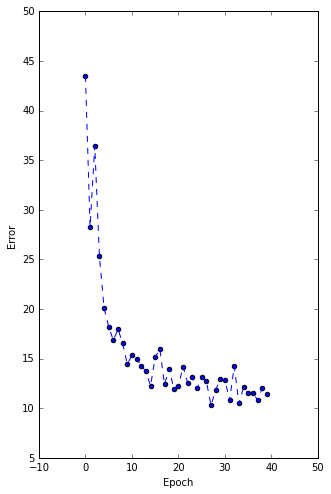

In [ ]:
plt.figure(figsize=(5,8))
plt.scatter(x, y, label="Error with each epoch")
plt.xlabel('Epoch')
plt.ylabel('Error')

plt.plot(x, y, ls="--")

In [ ]:
checkpoint = torch.load('weights.pt')

In [ ]:
net.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
net = net.to(device)

In [ ]:
_, valid_acc = infer(valid_queue, net, criterion)
print(valid_acc)

89.7
